# Chart individual seat probabilities

In [1]:
"""This notebook converts the odds from Sportsbet.com.au to probabilities,
And then sums those probabilities to find the new Parliament makeup that punters
believe is most likely."""

'This notebook converts the odds from Sportsbet.com.au to probabilities,\nAnd then sums those probabilities to find the new Parliament makeup that punters\nbelieve is most likely.'

## Python set-up

### Imports

In [2]:
import re
from functools import reduce
from typing import Callable, Final

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from IPython.display import display
import plotting

### Report on the operating environment

In [3]:
%load_ext watermark
%watermark --machine --python --iversions --conda

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.1.0

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas    : 2.2.3
re        : 2.2.1
matplotlib: 3.10.1
seaborn   : 0.13.2
numpy     : 2.2.5
IPython   : 9.1.0



### Plotting initialisation

In [4]:
def set_up_plotting() -> None:
    """Set up plotting."""

    p = plotting.get_chart_dir()
    plotting.set_chart_dir(p + "/individual-seats/")
    plotting.clear_chart_dir()


set_up_plotting()
SHOW = False

### Other initialisation

In [5]:
REMOVE_BRACKETS: Final[str] = r"\s*\(.*?\)"

## Get raw electorate betting data

In [6]:
def get_betting_data() -> pd.DataFrame:
    """Get the betting data from the local data file."""

    filename = "../betting-data/sportsbet-2025-electorate-betting.csv"
    df = pd.read_csv(
        filename, na_values=["SUS", "Suspended"], parse_dates=["timestamp"]
    )

    return df


BETTING_DF: Final[pd.DataFrame] = get_betting_data()

### Quick diagnostics on captured data

In [7]:
def diagnostics(df: pd.DataFrame) -> None:
    """Print diagnostics for the dataframe."""
    print(f"data shape: {df.shape}")
    print(f"data length: {len(df)}")
    print(f"data start: {df['timestamp'].min()}")
    print(f"data end: {df['timestamp'].max()}")
    print(f"data columns: {df.columns}")
    last = df["timestamp"].max()
    last_count = len(df[df["timestamp"] == last].seat.unique())
    print(
        f"Latest seat count: {last_count} rows)",
    )
    if last_count < 150:
        missing = set(df.seat) - set(df[df["timestamp"] == last].seat)
        print(f"Missing seats for most recent collection: {missing}")
    print(
        "Party groups:",
        df.party.str.replace(REMOVE_BRACKETS, "", regex=True).unique(),
    )


diagnostics(BETTING_DF)

data shape: (12530, 5)
data length: 12530
data start: 2025-03-30 23:21:13.467650
data end: 2025-04-23 07:01:11.412647
data columns: Index(['Unnamed: 0', 'seat', 'party', 'price', 'timestamp'], dtype='object')
Latest seat count: 150 rows)
Party groups: ['Labor' 'Coalition' 'Greens' 'Any Other Candidate' 'Independent'
 'One Nation' "Katter's Australian Party" 'Centre Alliance']


In [8]:
def display_raw(
    df: pd.DataFrame,  # seat betting data
    do_it: bool,  # whether to display the data
) -> None:
    """A useful presentation for checking the raw data.
    This is useful for understanding the data and checking
    for missing values."""

    if do_it:
        display(
            df.pivot(columns="timestamp", index=["seat", "party"], values="price")
            .T.tail(2)
            .T
        )


display_raw(df=BETTING_DF, do_it=False)

## Plot distribution of simple overrounds

In [9]:
def calculate_overrounds(
    df: pd.DataFrame,  # betting data
    seat: str,  # seat name
) -> pd.Series:
    """Calculate the bookmaker's overround at each timestamp
    for a given seat.  Returns a series with the overround for each
    timestamp.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The name of the seat to calculate overrounds for.
    Returns:
    pd.Series - A series containing the overround for each timestamp
    (the series index)."""

    seat_data = df[df["seat"] == seat]
    seat_overrounds = (
        seat_data.dropna(subset=["price"])  # Remove rows with no price
        .pivot(index="timestamp", columns="party", values="price")
        .pipe(lambda x: 1 / x)
        .sum(axis=1)
    )

    return seat_overrounds

In [10]:
def capture_latest_overrounds(
    df: pd.DataFrame,
    min_threshold: float = 1.06,
) -> pd.Series:
    """Capture the latest overrounds for each seat in the dataframe.
    In this process, report any seats with an overround less than
    the minimum threshold.  Note: overrounds may not all be for the
    exact same timestamp if some seats are missing data.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    min_threshold: float - The minimum expected bookmaker's overround.
    Returns:
    pd.Series - A series containing the overround for each seat,
    for that seat's latest timestamp."""

    # Filter out rows with missing prices
    df = df.dropna(subset=["price"])

    # Calculate the overround for each seat
    overrounds = {}
    for seat in df.seat.unique():
        overrounds[seat] = calculate_overrounds(df, seat).dropna().iloc[-1]
    series = pd.Series(overrounds)

    # Report any seats with an overround less than the minimum threshold
    too_low = series[series <= min_threshold]
    if len(too_low):
        print("We have some low (<= {min_threshold}) overrounds for:")
        for seat in too_low.index:
            print(
                seat,
                df[df.seat == seat]
                .pivot(index="timestamp", columns="party", values="price")
                .iloc[-1],
            )
        print("-" * 30)

    return series

We have some low (<= {min_threshold}) overrounds for:
Gorton (VIC) party
Any Other Candidate    26.00
Coalition                NaN
Labor                   1.02
Name: 2025-04-23 07:01:11.412647, dtype: float64
------------------------------


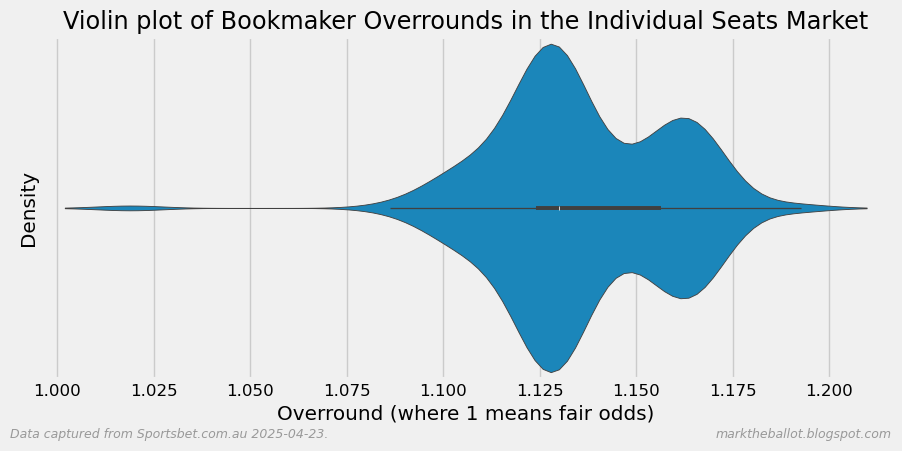

In [11]:
def plot_overrounds(df: pd.DataFrame) -> None:
    """
    Plot the latest overrounds for each seat in the dataframe.
    """
    overround_series = capture_latest_overrounds(df)
    ax = sns.violinplot(x=overround_series, orient="h")
    title = "Violin plot of Bookmaker Overrounds in the Individual Seats Market"
    plotting.finalise_plot(
        ax,
        title=title,
        ylabel="Density",
        xlabel="Overround (where 1 means fair odds)",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{df["timestamp"].max().date()}. ',
        show=True,
    )


plot_overrounds(BETTING_DF)

## Summarise latest results and identify seats of interest

In [12]:
def calc_probability(
    df: pd.DataFrame,  # DataFrame containing betting data
    seat: str,  # The seat to calculate probabilities for
    **kwargs,
) -> tuple[pd.DataFrame, str, pd.Index] | None:
    """Calculate the probability of winning for each party in a given seat.
    Note: this function makes some adjustments for (1) the bookmaker's
    overround, and (2) the favourite-longshot bias.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to calculate probabilities for.
    exclude_above: float - Exclude any odds above this value.
    lsb_cap: float - Only inflate odds if they are > lsb_cap.
    lsb_method: Callable | None - The method to use for inflating odds.
    Returns a tuple comprising:
    1. A DataFrame of seat probabilities
    2. A string explaining how the favourite-longshot bias was treated, and
    3. An index of dates with interpolated probabilities for missing odds."""

    # Favourite-Longshot Bias management:
    exclude_above: float = kwargs.get("exclude_above", 25.0)
    lsb_cap: float = kwargs.get("lsb_cap", 7.5)
    lsb_method: Callable | None = kwargs.get("lsb_method", lambda x: x * np.sqrt(x))
    method_text: str = kwargs.get("method_text", "raw-odds * sqrt(raw-odds)")

    # assume bookmaker's overround is at least 6%
    minimum_overround = 1.06

    # get the data for the seat
    seat_df = df[df.seat == seat]
    if seat_df.empty:
        print(f"No data for seat {seat}")
        return None

    # identify and replace missing odds, based on overround
    complete = pd.DatetimeIndex(sorted(df.timestamp.unique()))
    overs = calculate_overrounds(seat_df, seat)
    overs = overs.reindex(complete).fillna(minimum_overround - 1)
    pivot = seat_df.pivot(index="timestamp", columns="party", values="price")
    pivot = pivot.reindex(complete)
    pivot2 = pivot.where(overs >= minimum_overround, other=pivot.ffill())

    adjusted = (pivot.fillna(0) != pivot2.fillna(0)).sum(axis=1)
    adjusted_index = adjusted[adjusted > 0].index

    # remove any odds above the exclude_above threshold
    pivot2[pivot2 > exclude_above] = np.nan
    pivot2 = pivot2.dropna(axis=1, how="all")

    # get seat probabilities - treat for favourite-longshot bias
    seat_prob = (
        pivot2.pipe(  # type: ignore[call-overload]
            (
                lambda x: (
                    x
                    if lsb_method is None
                    else x.where(
                        x <= lsb_cap, other=lsb_method(x)  # type: ignore[arg-type, misc]
                    )
                )
            )
        )
        .pipe(lambda x: 1 / x)  # convert from odds to probability
        .pipe(lambda x: x.div(other=x.sum(axis=1), axis=0))  # normalise probabilities
    ) * 100  # per cent

    explainer = ""
    explanations = []
    if exclude_above > 0:
        explanations.append(f"Odds excluded above \\${exclude_above}")
    if lsb_method is not None:
        odds_cap = f", where odds > \\${lsb_cap}" if lsb_cap else ""
        explanations.append(f"{method_text}{odds_cap}")
    if explanations:
        explainer = "Favourite-Longshot Bias treatment: " + "; ".join(explanations)

    return seat_prob, explainer, adjusted_index

In [13]:
def colourise(s: str, count: int = 0) -> tuple[str, str]:
    """A standard color and marker scheme for parties."""

    settings = {
        "coalition": ("royalblue", "s"),
        "labor": ("#dd0000", "d"),
        "green": ("mediumseagreen", "o"),
        "independent": (
            ["darkorange", "orange", "purple", "teal"][count],
            "v>^<"[count],
        ),
        "one nation": ("darkkhaki", "H"),
        "jacqui lambie": ("darkorchid", "P"),
        "katter": ("hotpink", "X"),
        "centre alliance": ("brown", "P"),
        "other": ("skyblue", "|"),  # must be last
    }
    for party, setting in settings.items():
        if party in s.lower():
            return setting

    return ("gray", "*")


class Coloriser:
    """A class to handle colorisation of party names.
    Note: this is a bit of a hack, but it works for now.
    It allows for multiple independents to be colourised differently."""

    def __init__(self):
        self.x = {}

    def __call__(self, s: str) -> tuple[str, str]:
        core = re.sub(REMOVE_BRACKETS, "", s).strip()
        count = self.x.get(core, -1) + 1
        self.x[core] = count
        return colourise(s, count)


_color = Coloriser()
print(_color("Independent"))
print(_color("Independent"))

('darkorange', 'v')
('orange', '>')


Grouped probabilities for Calare (NSW): Index(['Coalition', 'Independent (Andrew Gee)', 'Independent (Kate Hook)'], dtype='object', name='party')
Grouped probabilities for Monash (VIC): Index(['Any Other Candidate', 'Coalition', 'Independent (Deb Leonard)',
       'Independent (Russell Broadbent)'],
      dtype='object', name='party')
Close seats:


,index,Top probability %,ahead
3,Brisbane (QLD),40.4,Labor
28,Ryan (QLD),46.7,Coalition
20,Macnamara (VIC),47.0,Labor
25,Paterson (NSW),49.5,Labor
0,Bennelong (NSW),50.0,"Coalition, Labor"
2,Bradfield (NSW),50.0,"Coalition, Independent (Nicolette Boele)"
21,McEwen (VIC),51.0,Labor
8,Curtin (WA),51.0,Independent (Kate Chaney)
18,Lyons (TAS),51.0,Coalition
6,Chisholm (VIC),51.0,Labor


Seats where Greens might be competitive:


,Greens win probability %
Melbourne (VIC),87.7
Griffith (QLD),57.1
Wills (VIC),42.7
Macnamara (VIC),37.4
Brisbane (QLD),35.0
Ryan (QLD),32.2
Richmond (NSW),29.1


Seats where Others might be competitive:


,Others win probability %
Clark (TAS),100.0
Kennedy (QLD),96.3
Warringah (NSW),86.8
Indi (VIC),80.3
Mayo (SA),79.9
Wentworth (NSW),78.4
Mackellar (NSW),69.4
Fowler (NSW),66.4
Goldstein (VIC),56.3
Curtin (WA),51.0


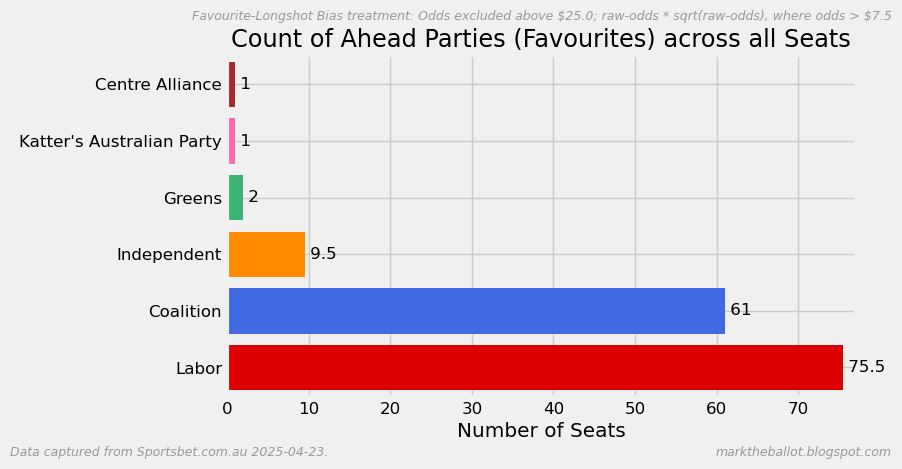

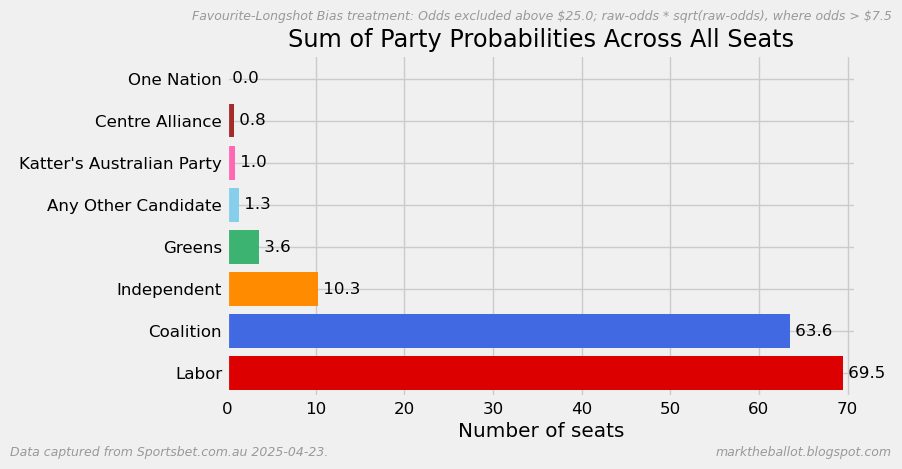

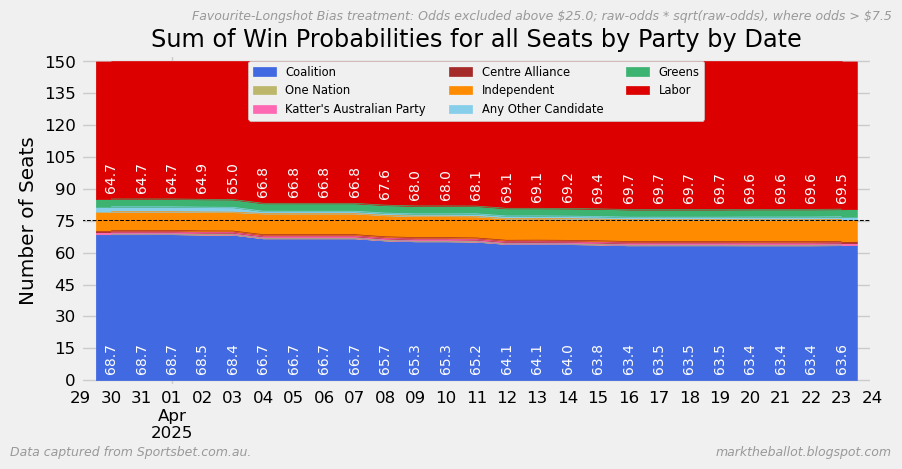

In [14]:
def plot_ahead_count(
    df: pd.DataFrame, party_count: dict[str, float], method: str  # betting data
) -> None:
    """Plot the count of the ahead party in each seat."""

    winners = pd.Series(party_count).sort_values(ascending=False)
    assert (
        winners.sum() == 150
    ), f"Count of ahead parties does not sum to 150; n={winners.sum()}"
    colors = [colourise(x)[0] for x in winners.index]
    _fig, ax = plt.subplots()
    ax.barh(winners.index, winners, color=colors)
    for i, v in enumerate(winners):
        rounded: str = f"{v:.1f}".rstrip("0").rstrip(".")
        ax.text(v, i, f" {rounded}", color="black", va="center", ha="left")  # type: ignore[arg-type]
    plotting.finalise_plot(
        ax,
        title="Count of Ahead Parties (Favourites) across all Seats",
        ylabel=None,
        xlabel="Number of Seats",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{df["timestamp"].max().date()}. ',
        rheader=method,
        show=True,
    )


def plot_party_prob_sum(
    df: pd.DataFrame, all_seats_probs: dict[str, pd.Series], method: str  # betting data
) -> None:
    """Plot the party-probability sums."""

    party_probs = pd.DataFrame(all_seats_probs).T.sum().sort_values(ascending=False)
    assert (
        149.9 < party_probs.sum() < 150.1
    ).all(), f"Probabilities do not sum to 150 seats; n={party_probs.sum()}"
    colors = [colourise(x)[0] for x in party_probs.index]
    _fig, ax = plt.subplots()
    ax.barh(party_probs.index, party_probs, color=colors)
    for i, v in enumerate(party_probs):
        ax.text(v, i, f" {v:0.1f}", color="black", va="center", ha="left")
    plotting.finalise_plot(
        ax,
        title="Sum of Party Probabilities Across All Seats",
        ylabel=None,
        xlabel="Number of seats",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{df["timestamp"].max().date()}. ',
        rheader=method,
        show=True,
    )


def tables_of_interest(
    all_seats_probs: dict[str, pd.Series],
    individual_leaders: dict[str, str],
) -> None:
    """Create tables of interest from the betting data."""

    # tavulate close seats
    seat_probs = pd.DataFrame(all_seats_probs).T * 100
    close_threshold = 70
    close_seats = seat_probs[seat_probs.max(axis=1) <= close_threshold]
    maxima = close_seats.max(axis=1).round(1)
    ahead = pd.Series(individual_leaders)[maxima.index]
    results = pd.DataFrame(
        {
            "Top probability %": maxima,
            "ahead": ahead,
        }
    )
    results = results.reset_index().sort_values(by="Top probability %", ascending=True)
    print("Close seats:")
    display(results)

    # Green possible seats
    green_threshold = 20
    greens = seat_probs["Greens"]
    green_competitive = (
        greens[greens >= green_threshold].sort_values(ascending=False).round(1)
    )
    print("Seats where Greens might be competitive:")
    frame = pd.DataFrame(green_competitive)
    frame.columns = pd.Index(["Greens win probability %"])
    display(frame)

    # Others possible
    other_threshold = 20
    others = seat_probs.drop(columns=["Greens", "Labor", "Coalition"]).sum(axis=1)
    other_competitive = others[others >= other_threshold].sort_values(ascending=False)
    print("Seats where Others might be competitive:")
    display(
        pd.DataFrame(other_competitive, columns=["Others win probability %"]).round(1)
    )


def order_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Order the columns of the DataFrame by party name."""

    first_columns = [
        f
        for f in (
            "Coalition",
            "One Nation",
            "Katter's Australian Party",
            "Centre Alliance",
        )
        if f in df.columns
    ]
    last_columns = [
        f for f in ("Any Other Candidate", "Greens", "Labor") if f in df.columns
    ]
    order = (
        first_columns
        + [x for x in df.columns if x not in first_columns + last_columns]
        + last_columns
    )
    return df.reindex(columns=order)


def plot_stacked_probs(
    df: pd.DataFrame,  # betting data
    all_seats_probs: dict[str, pd.Series],
    method: str,
) -> None:
    """Plot the stacked probabilities for each party."""

    # Create a DataFrame from the dictionary
    seat_probs = (pd.DataFrame(all_seats_probs).T * 100).sort_values(
        by="Labor", ascending=False
    )

    seat_probs = order_columns(seat_probs)
    colours = [colourise(x)[0] for x in seat_probs.columns]

    slices = [slice(0, 150), slice(0, 50), slice(50, 100), slice(100, 150)]
    for i, s in enumerate(slices):
        suffix = {0: "", 1: "(C)", 2: "(B)", 3: "(A)"}[i]
        size = {0: (9, 25), 1: (9, 9), 2: (9, 9), 3: (9, 9)}[i]
        lpos = {0: "lower right", 1: "lower right", 2: "lower right", 3: "lower center"}[
            i
        ]

        ax = seat_probs.iloc[s].plot.barh(stacked=True, color=colours)  # type: ignore[arg-type]
        ax.axvline(50, color="black", linestyle="-", linewidth=0.75)
        ax.margins(0.002)
        plotting.finalise_plot(
            ax,
            title=f"Stacked Win Probabilities for Each Seat {suffix}".strip(),
            ylabel=None,
            xlabel="Win Probability %",
            rfooter="marktheballot.blogspot.com",
            lfooter="Data captured from Sportsbet.com.au "
            + f'{df["timestamp"].max().date()}. ',
            rheader=method,
            show=False,
            legend={"loc": lpos, "fontsize": "x-small", "framealpha": 1.0},
            figsize=size,
        )


def data_collate(
    df: pd.DataFrame,
) -> tuple[
    dict[str, pd.Series], dict[str, str], dict[str, float], str, dict[str, pd.DataFrame]
]:
    """Collate the data for each seat, for the last avaiulable timestamp."""

    cum_seat_probs = {}  # {seat: dataframe_of_probabilities}
    latest_seat_probs = {}  # {seat: series_of_probabilities}
    party_ahead_count: dict[str, float] = {}  # {party: count}
    individual_leaders = {}  # {seat: party}

    for seat in df.seat.unique():
        # get latest seat probabilities
        p = calc_probability(df, seat)
        if p is None:
            print(f"CAUTION - THIS SHOULD NOT HAPPEN: No data for seat {seat}")
            continue
        seat_probs, method, _dates_missing_odds = p

        # agregate the probabilities over time
        probabs = seat_probs.copy()
        renamer = {}
        for col in probabs.columns:
            new_name = re.sub(REMOVE_BRACKETS, "", col).strip()
            if new_name != col:
                renamer[col] = new_name
        if renamer:
            probabs = probabs.rename(columns=renamer)
            probabs = probabs.T.groupby(probabs.columns).sum().T
        cum_seat_probs[seat] = probabs / 100  # convert to simplex

        # get and count the party/ies ahead - allow for fractional counts when tied
        latest = seat_probs.iloc[-1].dropna()
        maxima = latest.max()
        leaders = latest[latest == maxima].index.tolist()
        for leader in leaders:
            party = re.sub(REMOVE_BRACKETS, "", leader).strip()
            party_ahead_count[party] = party_ahead_count.get(party, 0) + (
                1 / len(leaders)
            )
        individual_leaders[seat] = ", ".join(leaders)

        # let's group probabilities by party name (ignore candidate names)
        renamer = {x: re.sub(REMOVE_BRACKETS, "", x).strip() for x in latest.index}
        groups = latest.rename(index=renamer)
        groups_combined = groups.groupby(
            groups.index
        ).sum()  # eg. more than one independent candidate
        if len(groups_combined) < len(groups):
            print(f"Grouped probabilities for {seat}: {latest.index}")
        latest_seat_probs[seat] = groups_combined / 100  # convert to simplex

    return (
        latest_seat_probs,
        individual_leaders,
        party_ahead_count,
        method,
        cum_seat_probs,
    )


def plot_prob_progres(
    seat_probs: dict[str, pd.DataFrame],  # betting data
    method: str,  # method used to calculate probabilities
) -> None:
    """Plot the progress of the probabilities for all seats over time."""

    aggregated = reduce(lambda a, b: a.add(b, fill_value=0), seat_probs.values())
    aggregated.index = pd.PeriodIndex(aggregated.index, freq="D")
    aggregated = aggregated[~aggregated.index.duplicated(keep="last")]
    aggregated = order_columns(aggregated).fillna(0)
    check = aggregated.sum(axis=1)
    assert (check > 149.9).all() and (
        check < 150.1
    ).all(), f"Probabilities do not sum to 150 seats; n={check}"

    _fig, ax = plt.subplots()
    ax.set_yticks(list(range(0, 151, 15)))
    ceiling = pd.Series(0, index=aggregated.index)
    color = Coloriser()
    x_ord = [x.ordinal for x in aggregated.index]
    x_ord[0] -= 0.5
    x_ord[-1] += 0.5

    for col in aggregated.columns:
        floor = ceiling
        ceiling = ceiling.add(aggregated[col])
        c, _m = color(col)
        ceiling.plot(ax=ax, color=c, linewidth=0.5, label="_")  # oddly required?
        # manage endpoints - so that we can write within the area
        # plot the area
        ax.fill_between(
            x_ord,
            floor,
            ceiling,
            label=col,
            color=c,
        )
        # add text/annotations for the larger values
        larger = 15
        if aggregated[col].mean() > larger:
            for x, y, s in zip(floor.index, floor, aggregated[col]):
                ax.text(
                    x,
                    y + 3,
                    f"{s:.1f}",
                    color="white",
                    va="bottom",
                    ha="center",
                    fontsize="small",
                    rotation=90,
                )
    # complete the plot
    plotting.finalise_plot(
        ax,
        title="Sum of Win Probabilities for all Seats by Party by Date",
        ylabel="Number of Seats",
        xlabel=None,
        rfooter="marktheballot.blogspot.com",
        rheader=method,
        lfooter="Data captured from Sportsbet.com.au. ",
        axhline={
            "y": 75.5,
            "color": "black",
            "linestyle": "--",
            "linewidth": 0.75,
        },
        legend={
            "loc": "upper center",
            "fontsize": "x-small",
            "framealpha": 1.0,
            "ncol": 3,
        },
        show=True,
    )


def summarise_seats_data(df: pd.DataFrame) -> None:
    """Summarise the individual seat betting data."""

    latest_seat_probs, individual_leaders, party_ahead_count, method, seat_probs = (
        data_collate(df)
    )

    tables_of_interest(latest_seat_probs, individual_leaders)

    plot_ahead_count(df, party_ahead_count, method)

    plot_party_prob_sum(df, latest_seat_probs, method)

    plot_prob_progres(seat_probs, method)

    plot_stacked_probs(df, latest_seat_probs, method)


summarise_seats_data(BETTING_DF)

## Plot individual seats

In [15]:
CHANGES = []  # list of seats with changes in the last two days - ugly hack


def plot_seat_probs(df: pd.DataFrame, seat: str) -> None:
    """
    Plot the seat probabilities for a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to plot.
    """

    # get seat probabilities - treat for favourite-longshot bias
    p = calc_probability(df, seat)
    if p is None:
        print(f"No data for seat {seat}")
        return
    seat_probs, flb_method, dates_missing_odds = p

    # make the index a daily period index and de-duplicate.
    seat_probs.index = pd.PeriodIndex(seat_probs.index, freq="D")
    seat_probs = seat_probs[~seat_probs.index.duplicated(keep="last")]
    if len(seat_probs) > 2 and (seat_probs.iloc[-1] != seat_probs.iloc[-2]).any():
        CHANGES.append(seat)
    missing_periods = pd.PeriodIndex(dates_missing_odds, freq="D")

    # plot
    ax = None
    color = Coloriser()
    for column in seat_probs.columns:
        c, m = color(column)
        ax = seat_probs[column].plot(
            ax=ax,
            markersize=6,
            lw=2.5,
            color=c,
            marker=m,
        )
        if seat_probs[column].iloc[-1] >= 10:
            ax.text(
                seat_probs.index[-1],
                seat_probs[column].iloc[-1],
                f"  {seat_probs[column].iloc[-1]:.0f}",
                fontsize=9,
                color="#444444",
                ha="left",
                va="center",
            )
    if ax is None:
        print(f"No data for seat {seat}")
        return

    if missing_periods is not None and len(missing_periods) > 0:
        label = "Missing odds"
        for period in missing_periods:  # type: ignore[attr-defined]
            ax.axvspan(
                period.ordinal - 0.5,
                period.ordinal + 0.5,
                color="gray",
                alpha=0.25,
                label=label,
            )
            label = "_nolegend_"

    plotting.finalise_plot(
        ax,
        title=f"Sportsbet seat win probabilities over time - {seat}",
        ylabel="Implied Win Probability (%)",
        lfooter=flb_method,
        rheader="marktheballot.blogspot.com",
        legend={"loc": "best", "ncol": 2, "fontsize": "small"},
        ylim=(-5, 105),
        y50=True,
        pre_tag="yy",
        show=SHOW,
    )


def plot_seat_odds(df: pd.DataFrame, seat: str) -> None:
    """
    Plot the seat odds for a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to plot.
    """

    # get seat odds - without FLB treatment
    df = df[df.seat == seat]
    odds = df.pivot(index="timestamp", columns="party", values="price")
    odds.index = pd.PeriodIndex(odds.index, freq="D")
    odds = odds[~odds.index.duplicated(keep="last")]
    odds = odds.sort_index(ascending=True)

    ax = None
    color = Coloriser()
    for column in odds.columns:
        c, m = color(column)
        ax = odds[column].plot(
            ax=ax,
            markersize=6,
            lw=2.5,
            color=c,
            marker=m,
        )
        value = odds[column].iloc[-1]
        if odds[column].iloc[-1] <= 31:
            rounding = 2 if value >= 1.01 else 3
            ax.text(
                odds.index[-1],
                value,
                f"  \\${value:.{rounding}f}",
                fontsize=9,
                color="#444444",
                ha="left",
                va="center",
            )

    if ax is None:
        print(f"No data for seat {seat}")
        return

    use_log_scale = False
    if use_log_scale:
        ax.set_yscale("log")
    minmax = ax.get_ylim()
    minmax = (0.9 if use_log_scale else 0, minmax[1])

    plotting.finalise_plot(
        ax,
        title=f"Sportsbet seat odds over time - {seat}",
        ylabel="$ Odds" + (" on a log scale" if use_log_scale else ""),
        lfooter="Decimal odds from Sportsbet.com.au",
        rfooter="marktheballot.blogspot.com",
        legend={"loc": "best", "ncol": 2, "fontsize": "small"},
        pre_tag="zz",
        ylim=minmax,
        show=SHOW,
    )


def plot_all_seats(df: pd.DataFrame) -> None:
    """Plot the seat probabilities for all seats."""

    for seat in df.seat.unique():
        plot_seat_probs(df, seat)
        plot_seat_odds(df, seat)

    if CHANGES:
        print("Seats with changes from penultimate day:", CHANGES)


plot_all_seats(BETTING_DF)

Seats with changes from penultimate day: ['Bass (TAS)', 'Bendigo (VIC)', 'Bennelong (NSW)', 'Calare (NSW)', 'Cunningham (NSW)', 'Dickson (QLD)', 'Dobell (NSW)', 'Eden-Monaro (NSW)', 'Farrer (NSW)', 'Fisher (QLD)', 'Flinders (VIC)', 'Franklin (TAS)', 'Fremantle (WA)', 'Gilmore (NSW)', 'Grey (SA)', 'Groom (QLD)', 'Hawke (VIC)', 'Hindmarsh (SA)', 'Hunter (NSW)', 'Longman (QLD)', 'Lyons (TAS)', 'Macquarie (NSW)', 'Melbourne (VIC)', 'Monash (VIC)', 'Paterson (NSW)', 'Whitlam (NSW)']


## Finished

In [16]:
print("finished")

finished
